# Segmentez les comportements des clients - Exploration

In [1]:
%%script echo skipping
from google.colab import drive
drive.mount('/content/drive')

skipping


# SOMMAIRE
* [PREPARATION](#PREPARATION)
* [CHARGEMENT](#CHARGEMENT)
* [CARACTERISTIQUES](#CARACTERISTIQUES)
* [EXPLORATION](#EXPLORATION)
    * [Client](#Client)
    * [Panier Moyen](#Panier-Moyen)
    * [Vente](#Vente)
    * [Produit](#Produit)

# PREPARATION

## Import des librairies

In [2]:
import matplotlib as mplt
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd
import seaborn as sns
import joblib
import datetime
import numpy as np
from datetime import timedelta
import collections


## Paramétrage du notebook

In [3]:
sns.set(font='Franklin Gothic Book',rc={
 'axes.axisbelow': False,
 'axes.edgecolor': 'lightgrey',
 'axes.facecolor': 'None',
 'axes.grid': False,
 'axes.labelcolor': 'dimgrey',
 'axes.spines.right': False,
 'axes.spines.top': False,
 'figure.facecolor': 'white',
 'lines.solid_capstyle': 'round',
 'patch.edgecolor': 'w',
 'patch.force_edgecolor': True,
 'text.color': 'dimgrey',
 'xtick.bottom': False,
 'xtick.color': 'dimgrey',
 'xtick.direction': 'out',
 'xtick.top': False,
 'ytick.color': 'dimgrey',
 'ytick.direction': 'out',
 'ytick.left': False,
 'ytick.right': False})

#mplt.font_manager._rebuild()

pd.set_option('display.min_rows', 15)

## Declaration des fonctions

In [4]:
def profil(df):
    """
    Fonction qui retourne le profil des données d'un dataframe (moyenne, ecart type, min, max, valeurs manquantes, valeurs uniques)

    Parameters
    ----------
    df : DataFrame
        un DataFrame de données

    Returns
    -------
    result : DataFrame
        un DataFrame de profil, contenant un résumé statistique des données
    """
    
    dfValeursManquantes=pd.concat([df.isna().sum(),100*df.isna().sum()/len(df)],axis=1,keys=["missing_values","%_missing_values"])
    dfTypes=pd.DataFrame({'type':df.dtypes})
    result=df.describe(include='all',datetime_is_numeric=True).T
    result=result.merge(dfTypes,left_index=True,right_index=True)
    result=result.merge(dfValeursManquantes,left_index=True,right_index=True)
    return result

def summarizeFrequenciesDf(df,threshold):
    """
    Fonction mode qui agrege les variables qui sont sous un seuil 'threshold'(pour les très gros dataframe qui ont du mal à plotter)

    Parameters
    ----------
    df : DataFrame
        un DataFrame de données
    threshold: Int
        seuil au dessous duquel le comptage des observations sont agrégées dans la catégorie 'autres'

    Returns
    -------
    result : DataFrame
        un DataFrame contenant le comptage des observations au dessus du seuil et tout le reste dans la catégorie 'Autres'
    """

    dfFrequencies=df.value_counts()
    dfNormalizedFrequencies=df.value_counts(normalize=True) # frequence normalisée des valeurs de chaque variable
    mask = dfNormalizedFrequencies>threshold # masque sur les fréquences > seuil
    dfTail= dfFrequencies.loc[~mask].sum()
    dfFrequencies=dfFrequencies.loc[mask] # filtre sur les fréquences < seuil
    dfFrequencies['Autres']=dfTail # ajout des fréquences > seuil agregées dans la categorie 'Autre'
    return pd.DataFrame(dfFrequencies)

def plotCategoricalDistributions(plt,df,nrows,ncols,subfigwidth,subfigheight):
    """
    Fonction affiche les distributions des variables categorielles d'un DataFrame

    Parameters
    ----------
    plt: plot
        un objet pyplot qui affiche les graphiques
    df : DataFrame
        un DataFrame de données
    nrows: Int
        nombre de lignes des sous-figures
    ncols: Int
        nombre de colonnes des sous-figures
    subfigwidth: Int
        largeur des sous-figures
    subfigheight: Int
        hauteur des sous-figures

    
    Returns
    -------
    Pas de retours, c'est une procédure d'affichage

    """
    dfCategorical=df.select_dtypes(include=['object','string', 'category'])
    
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols,figsize=(subfigwidth,subfigheight))

    # Titre
    fig.suptitle("Distribution Variables Categorielles", fontsize=20)
    fig.subplots_adjust(top=1.5)
    
    # axes est un tableau à 2 dimensions: lignes, colonnes
    # pour parcourir les subplot, il faut réduire axes à une dimension avec flatten
    axes=axes.flatten()
    
    # espace vertical entre les rangées de sous graphiques
    plt.tight_layout(pad=3)
    
    i=0
    for x in dfCategorical.columns:
        # passe les labels sur l'axe des x en arriere plan
        axes[i].xaxis.label.set_visible(False)
        
        # On classe dans la categorie "Autres" les variables sous le seuil de 0,5% de frequence d'observation,
        dfCurrent=summarizeFrequenciesDf(dfCategorical[x],0.005)
    
        axes[i].bar(dfCurrent[x].index,dfCurrent[x],color='#ee6352')
        axes[i].tick_params(axis='x', rotation=-90)
        axes[i].set_title(x,color='#3fa7d6')
    
        i=i+1
    plt.show()
        
def plotQuantitativeDistributions(plt,df,nrows,ncols,subfigwidth,subfigheight):
    """
    Fonction affiche les distributions des variables quantitatives d'un DataFrame

    Parameters
    ----------
    plt: plot
        un objet pyplot qui affiche les graphiques
    df : DataFrame
        un DataFrame de données
    nrows: Int
        nombre de lignes des sous-figures
    ncols: Int
        nombre de colonnes des sous-figures
    subfigwidth: Int
        largeur des sous-figures
    subfigheight: Int
        hauteur des sous-figures
    
    Returns
    -------
    Pas de retours, c'est une procédure d'affichage

    """
    dfQuantitative=df.select_dtypes(exclude=['object','string', 'category'])
    dfQSkew=dfQuantitative.skew(skipna = True).to_frame('SKEW')
    dfQColumnsSorted=dfQSkew.sort_values(by='SKEW',ascending=False).T.columns #tri des colonnes par valeur de skew

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols,figsize=(subfigwidth,subfigheight))
    
    # Titre
    fig.suptitle("Distribution Variables Quantitatives", fontsize=20)
    fig.subplots_adjust(top=1.5)
    
    # axes est un tableau à 2 dimensions: lignes, colonnes
    # pour parcourir les subplot, il faut réduire axes à une dimension avec flatten
    axes=axes.flatten()
    
    # espace vertical entre les rangées de sous graphiques
    plt.tight_layout(pad=3)
    
    dfQuantitative
    i=0
    for x in dfQColumnsSorted:
        #dfCurrent=dfNumerical[x].sample(1000,replace=True).sort_index() #optimisation pour les large datasets
        dfCurrent=dfQuantitative[x].dropna(axis=0)
        # passe les labels sur l'axe des x en arriere plan
        axes[i].xaxis.label.set_visible(False)    
        
        axes[i].hist(dfCurrent,color='#3fa7d6')
        axes[i].tick_params(axis='x', rotation=-90)
        axes[i].set_title(x,color='#ee6352')
    
        i=i+1
    plt.show()

def plotCorrelationHeatmap(plt,df):
    """
    Fonction affiche la heatmap des correlation d'un DataFrame

    Parameters
    ----------
    plt: plot
        un objet pyplot qui affiche les graphiques
    df : DataFrame
        un DataFrame de données
    
    Returns
    -------
    Pas de retours, c'est une procédure d'affichage

    """
    dfCorr=df.corr()
    plt.rcParams["figure.figsize"] = (10,10)
    plt.matshow(dfCorr,cmap='coolwarm',interpolation='nearest')
    plt.xticks(range(len(dfCorr.columns)), dfCorr.columns, size='small',rotation='vertical');
    plt.yticks(range(len(dfCorr.columns)), dfCorr.columns, size='small');
    plt.show()
    
def plotBoxes(plt,df,nrows,ncols):
    """
    Fonction affiche les boites à moustache des variables quantitatives d'un DataFrame

    Parameters
    ----------
    plt: plot
        un objet pyplot qui affiche les graphiques
    df : DataFrame
        un DataFrame de données
    nrows: Int
        nombre de lignes des sous-figures
    ncols: Int
        nombre de colonnes des sous-figures
    
    Returns
    -------
    Pas de retours, c'est une procédure d'affichage
    """
    dfQuantitative=df.select_dtypes(exclude=['object','string', 'category'])

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols,figsize=(14,20))
    
    # espace vertical entre les rangées de sous graphiques
    plt.tight_layout(pad=3)


    # axes est un tableau à 2 dimensions: lignes, colonnes
    # pour parcourir les subplot, il faut réduire axes à une dimension avec flatten
    axes=axes.flatten()
    
    i=0
    for x in dfQuantitative.columns:
            axes[i].boxplot(dfQuantitative[x].dropna())
            axes[i].set_title(x,color='#3fa7d6')
            i+=1
    plt.show()

def plot_barh(data, title=None, fig_width=None, color='#43aa8b', fmt='.0f'):
    """Horizontal barplot for a Series
    """

    if not fig_width:
        fig_width = 12
    
    figsize = (fig_width, 0.4 * data.shape[0])

    fig, ax = plt.subplots(figsize=figsize)
    data.plot.barh(ax=ax, color=color)
    plt.gca().invert_yaxis()

    if not title and hasattr(data, "name"):
        title = data.name

    if title:
        ax.set_title(title, fontweight='bold')    

    ax.xaxis.tick_top()
    ax.yaxis.grid(False)

    width_in_pix = figsize[0] * fig.get_dpi()
    width_in_val = max(data.values)

    N_PIXELS_OFFSET = 2
    offset = N_PIXELS_OFFSET * width_in_val / width_in_pix

    for i, val in enumerate(data.values):
        ax.text(
            val + offset, i, format(val, fmt), 
            color=color, fontweight='bold', va='center'
        )

    return ax

# CHARGEMENT

In [5]:
#df=pd.read_excel("OnlineRetail.xlsx", engine='openpyxl')

In [6]:
#joblib.dump(df,"dfOnlineRetail.jbl.bz2")

In [7]:
#df=joblib.load("drive/MyDrive/Colab Notebooks/Datasets/dfCleaned.jbl.bz2")
df=joblib.load("dfCleaned.jbl.bz2")

# CARACTERISTIQUES

## Profil

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392689 entries, 0 to 541908
Data columns (total 14 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   InvoiceNo          392689 non-null  object        
 1   StockCode          392689 non-null  object        
 2   Description        392689 non-null  object        
 3   Quantity           392689 non-null  int64         
 4   InvoiceDate        392689 non-null  datetime64[ns]
 5   UnitPrice          392689 non-null  float64       
 6   CustomerID         392689 non-null  float64       
 7   Country            392689 non-null  object        
 8   TotalPrice         392689 non-null  float64       
 9   Year               392689 non-null  object        
 10  Month              392689 non-null  object        
 11  InvoiceDateSimple  392689 non-null  object        
 12  InvoiceDateYM      392689 non-null  object        
 13  CountryGroup       392689 non-null  object  

In [9]:
df.sample(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,Year,Month,InvoiceDateSimple,InvoiceDateYM,CountryGroup
349365,567504,22114,HOT WATER BOTTLE TEA AND SYMPATHY,4,2011-09-20 14:33:00,3.95,13356.0,United Kingdom,15.80,2011,09,2011-09-20,2011-09,UK
338856,566567,22385,JUMBO BAG SPACEBOY DESIGN,10,2011-09-13 12:37:00,2.08,16161.0,United Kingdom,20.80,2011,09,2011-09-13,2011-09,UK
132150,547656,23004,TRAVEL CARD WALLET PANTRY,2,2011-03-24 12:53:00,0.42,13263.0,United Kingdom,0.84,2011,03,2011-03-24,2011-03,UK
435978,574079,22158,3 HEARTS HANGING DECORATION RUSTIC,1,2011-11-02 16:19:00,2.95,17595.0,United Kingdom,2.95,2011,11,2011-11-02,2011-11,UK
86756,543597,21272,SALLE DE BAIN HOOK,12,2011-02-10 12:32:00,1.25,12857.0,United Kingdom,15.00,2011,02,2011-02-10,2011-02,UK


In [10]:
dfProfil=profil(df)
dfProfil

,count,unique,top,freq,mean,min,25%,50%,75%,max,std,type,missing_values,%_missing_values
InvoiceNo,392689,18529,576339,542,NaN,NaN,NaN,NaN,NaN,NaN,NaN,object,0,0.0
StockCode,392689,3665,85123A,2023,NaN,NaN,NaN,NaN,NaN,NaN,NaN,object,0,0.0
Description,392689,3877,WHITE HANGING HEART T-LIGHT HOLDER,2016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,object,0,0.0
Quantity,392689.0,NaN,NaN,NaN,13.152716,1.0,2.0,6.0,12.0,80995.0,181.596931,int64,0,0.0
InvoiceDate,392689,NaN,NaN,NaN,2011-07-10 19:19:07.882420736,2010-12-01 08:26:00,2011-04-07 11:16:00,2011-07-31 12:02:00,2011-10-20 12:53:00,2011-12-09 12:50:00,NaN,datetime64[ns],0,0.0
UnitPrice,392689.0,NaN,NaN,NaN,3.093796,0.0,1.25,1.95,3.75,8142.75,20.565579,float64,0,0.0
CustomerID,392689.0,NaN,NaN,NaN,15287.863671,12346.0,13955.0,15150.0,16791.0,18287.0,1713.519206,float64,0,0.0
Country,392689,37,United Kingdom,349198,NaN,NaN,NaN,NaN,NaN,NaN,NaN,object,0,0.0
TotalPrice,392689.0,NaN,NaN,NaN,22.595468,0.0,4.95,12.39,19.8,168469.6,310.984565,float64,0,0.0
Year,392689,2,2011,367026,NaN,NaN,NaN,NaN,NaN,NaN,NaN,object,0,0.0


# EXPLORATION

## Client

La méthode de segmentation RFM permet un classement des clients en fonction de leurs habitudes d'achat. On peut ainsi optimiser une stratégie marketing en fonction de nos clients.

Le classement RFM se fait en fonction de 3 critères :

* Récence : date du dernier achat ou dernier contact client
* Fréquence : fréquence des achats sur une période de référence donnée
* Montant : somme des achats cumulés sur cette période

In [11]:
# Creer la date de reference
date_reference = df['InvoiceDate'].max()# + timedelta(days=1)

print(date_reference)

# RFM groupé par client
dfRFMc = df.groupby(['CustomerID']).agg({
        'Country': lambda x: pd.Series.mode(x)[0],
        'CountryGroup': lambda x: pd.Series.mode(x)[0],
        'InvoiceDate': lambda x: (date_reference - x.max()).days, #temps ecoulé depuis le dernier achat
        'InvoiceNo': 'count',
        'TotalPrice': 'sum'})

# frequence sur 7 jours
dfRFMc['Frequence7'] = (df.groupby('CustomerID').InvoiceNo.nunique() / 
    (date_reference - df.groupby('CustomerID').InvoiceDate.min()).dt.days * 7)
with pd.option_context('mode.use_inf_as_na', True):
        mean_freq = dfRFMc['Frequence7'].mean(skipna=True)
dfRFMc['Frequence7']=dfRFMc['Frequence7'].replace(np.inf, mean_freq) #remplacement des valeurs infinies par la moyenne

# Renomme les colonnes 
dfRFMc.rename(columns={'InvoiceDate': 'Recence',
                         'InvoiceNo': 'Frequence',
                         'TotalPrice': 'Montant'}, inplace=True)
#joblib.dump(dfRFMc,'drive/MyDrive/Colab Notebooks/Datasets/dfRFMc.jbl.bz2')
dfRFMc=dfRFMc.sort_values(['Recence','Frequence','Montant'], ascending=[True,False,False])
joblib.dump(dfRFMc,'dfRFMc.jbl.bz2')

2011-12-09 12:50:00


['dfRFMc.jbl.bz2']

findfont: Font family ['Franklin Gothic Book'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Franklin Gothic Book'] not found. Falling back to DejaVu Sans.


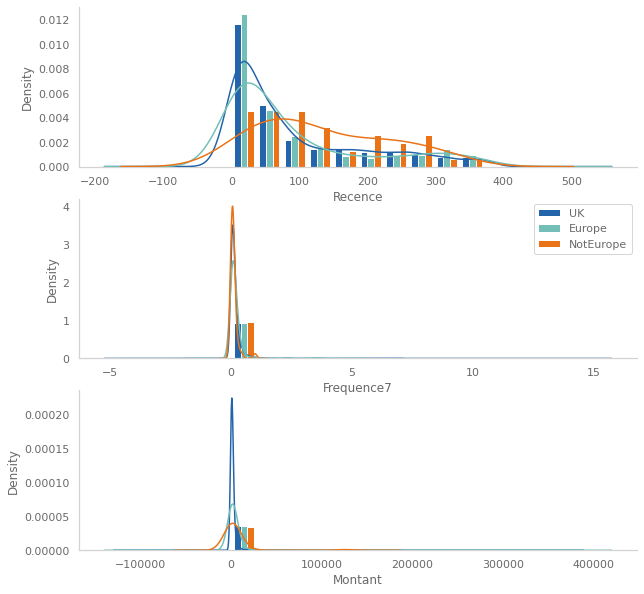

In [12]:
# Histogramme R, F et M

plt.figure(figsize=(10,10))
colors=['#2364aa', '#73bfb8','#ea7317']
bins=10

# RECENCE
plt.subplot(3, 1, 1);
plt.hist(
    [dfRFMc[dfRFMc['CountryGroup']=='UK']['Recence'],
     dfRFMc[dfRFMc['CountryGroup']=='Europe']['Recence'],
     dfRFMc[dfRFMc['CountryGroup']=='NotEurope']['Recence']],
     color=colors,
     label=['UK','Europe','NotEurope'],
     density=True,
     bins=bins);
#plt.legend()
plt.xlabel('Recence')
plt.ylabel('Frequence7')

# plot KDE (kernel density estimation)
dfRFMc[dfRFMc['CountryGroup']=='UK']['Recence'].plot.kde(zorder=4, color=colors[0])
dfRFMc[dfRFMc['CountryGroup']=='Europe']['Recence'].plot.kde(zorder=4, color=colors[1])
dfRFMc[dfRFMc['CountryGroup']=='NotEurope']['Recence'].plot.kde(zorder=4, color=colors[2])


# FREQUENCE
plt.subplot(3, 1, 2);

plt.hist(
    [dfRFMc[dfRFMc['CountryGroup']=='UK']['Frequence7'],
     dfRFMc[dfRFMc['CountryGroup']=='Europe']['Frequence7'],
     dfRFMc[dfRFMc['CountryGroup']=='NotEurope']['Frequence7']],
     color=colors,
     label=['UK','Europe','NotEurope'],
     density=True,
     bins=bins);
plt.legend()
plt.xlabel('Frequence7')
plt.ylabel('Frequence7')

# plot KDE
dfRFMc[dfRFMc['CountryGroup']=='UK']['Frequence7'].plot.kde(zorder=2, color=colors[0])
dfRFMc[dfRFMc['CountryGroup']=='Europe']['Frequence7'].plot.kde(zorder=2, color=colors[1])
dfRFMc[dfRFMc['CountryGroup']=='NotEurope']['Frequence7'].plot.kde(zorder=2, color=colors[2])

# MONTANT
plt.subplot(3, 1, 3);
plt.hist(
    [dfRFMc[dfRFMc['CountryGroup']=='UK']['Montant'],
     dfRFMc[dfRFMc['CountryGroup']=='Europe']['Montant'],
     dfRFMc[dfRFMc['CountryGroup']=='NotEurope']['Montant']],
     color=colors,
     label=['UK','Europe','NotEurope'],
     density=True,
     bins=bins);
#plt.legend()
plt.xlabel('Montant')
plt.ylabel('Frequence7')

# plot KDE
dfRFMc[dfRFMc['CountryGroup']=='UK']['Montant'].plot.kde(zorder=4, color=colors[0])
dfRFMc[dfRFMc['CountryGroup']=='Europe']['Montant'].plot.kde(zorder=4, color=colors[1])
dfRFMc[dfRFMc['CountryGroup']=='NotEurope']['Montant'].plot.kde(zorder=4, color=colors[2])

plt.show()


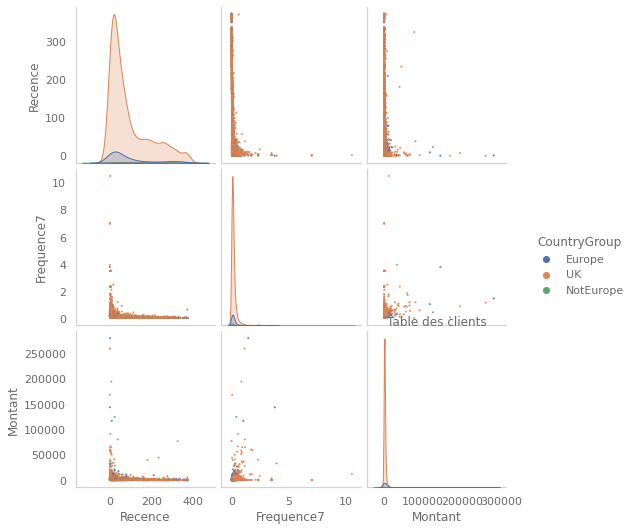

In [13]:
#pairplot RFM
sns.pairplot(dfRFMc[['Recence','Frequence7','Montant','CountryGroup']], hue="CountryGroup", plot_kws={'s': 3, "edgecolor": None})
plt.title("Table des clients")
plt.show()

In [14]:
# decoupage du dataframe RFM par périodes de date (pour les cross validation lors de la modélisation)

# definition de 3 periodes à partir du dataset d'origine
kfold=3
fold={}

size=int(np.floor(len(df.index)/kfold))
i=0
for start in range(0, len(df), size):
    fold[i]=df[start:start+size]
    i+=1
fold

{0:        InvoiceNo StockCode                          Description  Quantity  \
 0         536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
 1         536365     71053                  WHITE METAL LANTERN         6   
 2         536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
 3         536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
 4         536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
 5         536365     22752         SET 7 BABUSHKA NESTING BOXES         2   
 6         536365     21730    GLASS STAR FROSTED T-LIGHT HOLDER         6   
 ...          ...       ...                                  ...       ...   
 192464    553417     23173                REGENCY TEAPOT ROSES          2   
 192465    553417     23174             REGENCY SUGAR BOWL GREEN         6   
 192466    553417     23175               REGENCY MILK JUG PINK          6   
 192467    553417     23088     ZINC HEART FLOWER T-LIGHT HOL

In [15]:
# creation de dataframe RFM sur les k periodes (fold), contenu dans un dictionnaire indexé sur k
dictRFMPeriod={}
#for i in fold.keys():
for i in range(0, 3):
    dfCurrent=fold[i]
    
    # Creer la date de reference
    date_reference = dfCurrent['InvoiceDate'].max()# + timedelta(days=1)
    
    print(f"date max période[{i}]:{date_reference}")
    
    dfRFMCurrent = dfCurrent.groupby(['CustomerID']).agg({
            'Country': lambda x: pd.Series.mode(x)[0],
            'CountryGroup': lambda x: pd.Series.mode(x)[0],
            'InvoiceDate': lambda x: (date_reference - x.max()).days, #temps ecoulé depuis le dernier achat
            'InvoiceNo': 'count',
            'TotalPrice': 'sum'})
        
    # Renomme les colonnes 
    dfRFMCurrent.rename(columns={'InvoiceDate': 'Recence',
                             'InvoiceNo': 'Frequence',
                             'TotalPrice': 'Montant'}, inplace=True)
    #joblib.dump(dfRFMc,'drive/MyDrive/Colab Notebooks/Datasets/dfRFMc.jbl.bz2')
    dfRFMCurrent=dfRFMCurrent.sort_values(['Recence','Frequence','Montant'], ascending=[True,False,False])
    dictRFMPeriod[i]=dfRFMCurrent

date max période[0]:2011-05-17 10:08:00
date max période[1]:2011-09-29 15:58:00
date max période[2]:2011-12-09 12:50:00


In [16]:
joblib.dump(dictRFMPeriod,'dictRFMPeriod.jbl.bz2')

['dictRFMPeriod.jbl.bz2']

## Panier Moyen

In [17]:
#Panier moyen par jour glissant
# Creer la date de reference
date_reference = df['InvoiceDate'].max() + timedelta(days=1)

print(date_reference)

dfPanierMoyen = df.groupby(['CustomerID']).agg({
        'InvoiceDate': lambda x: (date_reference - x.max()).days/7,
        'TotalPrice': 'sum'})
# Renomme les colonnes 
dfPanierMoyen.rename(columns={'TotalPrice': 'PanierMoyen'}, inplace=True)
dfPanierMoyen

2011-12-10 12:50:00


,InvoiceDate,PanierMoyen
CustomerID,,
12346.0,46.571429,77183.60
12347.0,0.285714,4310.00
12348.0,10.714286,1797.24
12349.0,2.714286,1757.55
12350.0,44.285714,334.40
12352.0,5.142857,1665.74
12353.0,29.142857,89.00
...,...,...
18277.0,8.285714,110.38


/Users/hui-guan/opt/miniconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


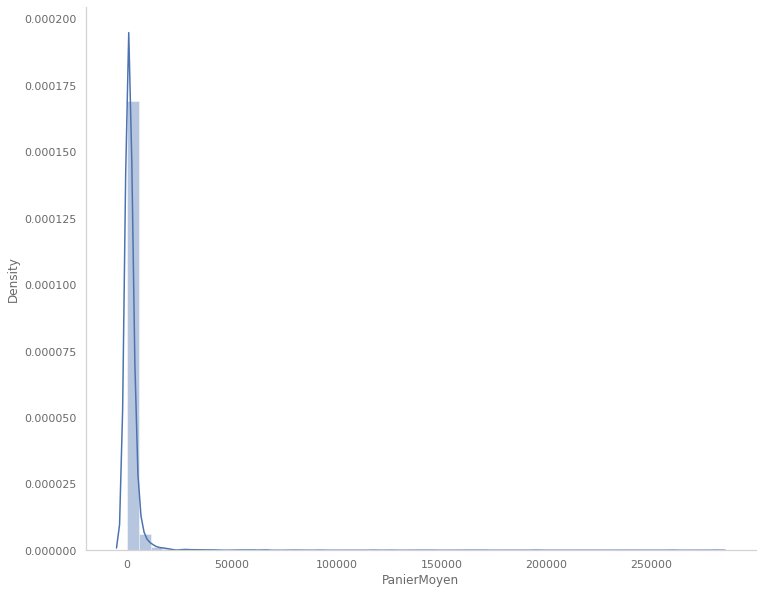

In [18]:
plt.figure(figsize=(12,10))
sns.distplot(dfPanierMoyen['PanierMoyen'])
plt.show()

In [19]:
dfPanierMoyen=pd.concat([df.groupby('Country')['TotalPrice'].mean(),df.groupby('Country')['TotalPrice'].sum()],axis=1)
dfPanierMoyen.columns = ['Moyenne', 'Somme']
dfPanierMoyen

,Moyenne,Somme
Country,,
Australia,116.937340,138453.810
Austria,25.624824,10198.680
Bahrain,32.258824,548.400
Belgium,20.283772,41196.340
Brazil,35.737500,1143.600
Canada,24.280662,3666.380
Channel Islands,27.363507,20440.540
Cyprus,22.392786,13502.850
Czech Republic,33.069600,826.740


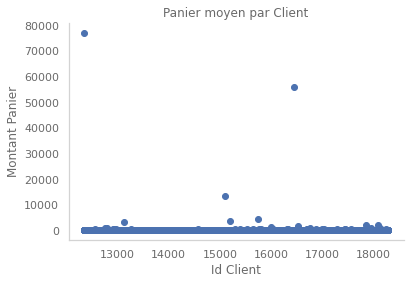

In [20]:
# Classement des paniers moyens des clients
dfPaniermoyenClient=df.groupby('CustomerID').agg({'TotalPrice':'mean'}).sort_values(by='TotalPrice', ascending=False)
plt.scatter(dfPaniermoyenClient.index,dfPaniermoyenClient['TotalPrice'])
plt.title('Panier moyen par Client')
plt.xlabel('Id Client')
plt.ylabel('Montant Panier')
plt.show()

In [21]:
# Les 10 client qui depensent le plus et le moins
dfPaniermoyenClient.head(10),dfPaniermoyenClient.tail(10)

(              TotalPrice
 CustomerID              
 12346.0     77183.600000
 16446.0     56157.500000
 15098.0     13305.500000
 15749.0      4453.430000
 15195.0      3861.000000
 13135.0      3096.000000
 17846.0      2033.100000
 18087.0      2027.860000
 16532.0      1687.200000
 16000.0      1377.077778,
             TotalPrice
 CustomerID            
 13521.0       2.563947
 15060.0       2.558696
 17832.0       2.547049
 15850.0       2.525591
 17254.0       2.443153
 13271.0       2.430920
 13684.0       2.245862
 17816.0       2.150588
 15503.0       2.136970
 13256.0       0.000000)

## Vente

In [22]:
# aggregation par vente unitaire
last_order = df.InvoiceDate.max()
ventes = df.groupby('InvoiceNo').agg({
    'InvoiceDate': ['max', 
                    lambda x: (last_order - pd.Series.max(x)).days],
    'CustomerID': lambda x: pd.Series.mode(x, dropna=False)[0],
    'Country': lambda x: pd.Series.mode(x)[0],
    'CountryGroup': lambda x: pd.Series.mode(x)[0],
    'StockCode': [list, 
                  len],
    'Quantity': 'sum',
    'TotalPrice': 'sum'
})

ventes.columns = [
    'InvoiceDate', 'Recency', 'CustomerID', 'Country', 'CountryGroup',
    'Items', 'NumberOfLines', 'TotalQty', 'TotalPrice'
]

ventes['InvoiceDateSimple']=ventes['InvoiceDate'].dt.date
ventes.head()

,InvoiceDate,Recency,CustomerID,Country,CountryGroup,Items,NumberOfLines,TotalQty,TotalPrice,InvoiceDateSimple
InvoiceNo,,,,,,,,,,
536365,2010-12-01 08:26:00,373,17850.0,United Kingdom,UK,"[85123A, 71053, 84406B, 84029G, 84029E, 22752,...",7,40,139.12,2010-12-01
536366,2010-12-01 08:28:00,373,17850.0,United Kingdom,UK,"[22633, 22632]",2,12,22.20,2010-12-01
536367,2010-12-01 08:34:00,373,13047.0,United Kingdom,UK,"[84879, 22745, 22748, 22749, 22310, 84969, 226...",12,83,278.73,2010-12-01
536368,2010-12-01 08:34:00,373,13047.0,United Kingdom,UK,"[22960, 22913, 22912, 22914]",4,15,70.05,2010-12-01
536369,2010-12-01 08:35:00,373,13047.0,United Kingdom,UK,[21756],1,3,17.85,2010-12-01


<Figure size 2160x2160 with 0 Axes>

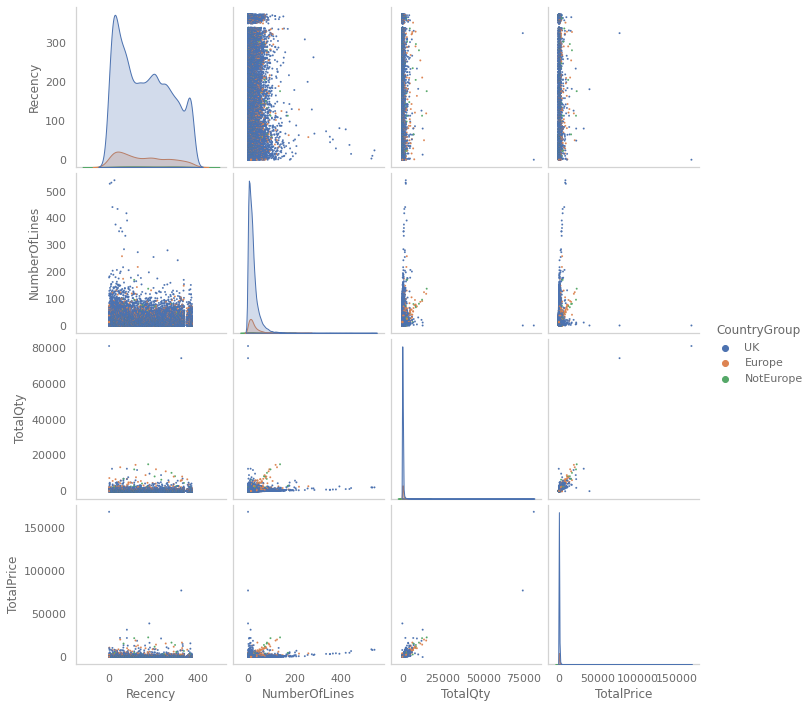

CPU times: user 13.6 s, sys: 210 ms, total: 13.8 s
Wall time: 11.1 s


In [23]:
%%time
plt.figure(figsize=(30,30))
sns.pairplot(
    data=ventes[['Recency', 'NumberOfLines', 'TotalQty' ,'TotalPrice', 'CountryGroup']],
    hue='CountryGroup',
    plot_kws={'s': 3, "edgecolor": None},
)
plt.show()

findfont: Font family ['Franklin Gothic Book'] not found. Falling back to DejaVu Sans.


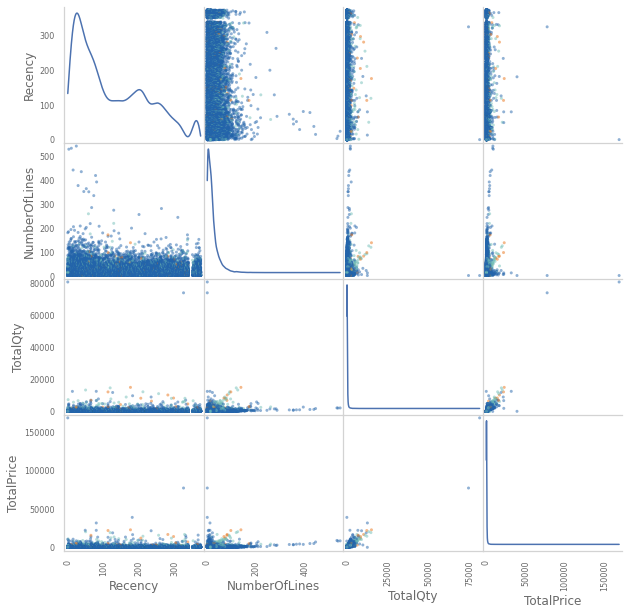

CPU times: user 7.08 s, sys: 159 ms, total: 7.24 s
Wall time: 3.39 s


In [24]:
%%time
# pairplot rapide
colors={'UK':'#2364aa', 'Europe':'#73bfb8','NotEurope':'#ea7317'}
pd.plotting.scatter_matrix(ventes[['Recency', 'NumberOfLines', 'TotalQty' ,'TotalPrice', 'CountryGroup']],c=[colors[x] for x in ventes['CountryGroup']],diagonal='kde',figsize=(10,10));
plt.show()

findfont: Font family ['Franklin Gothic Book'] not found. Falling back to DejaVu Sans.


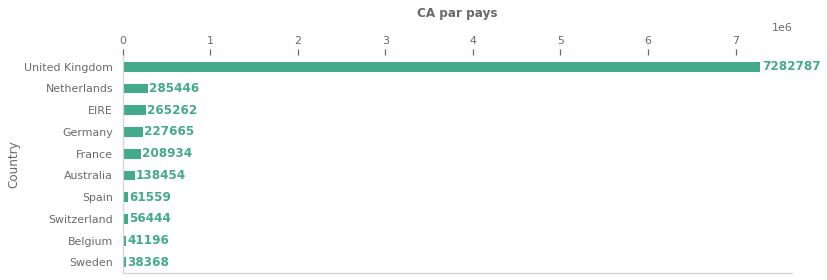

In [25]:
plot_barh(ventes.groupby('Country').TotalPrice.sum().sort_values(ascending=False).head(10),
          title="CA par pays")
plt.show()

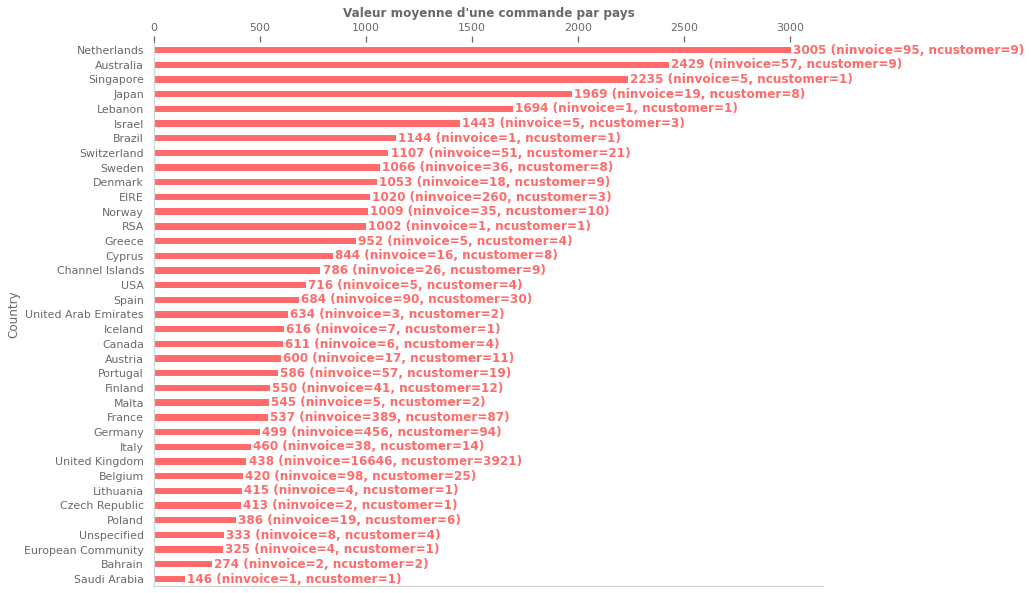

In [26]:
means = ventes.groupby('Country').TotalPrice.mean().sort_values(ascending=False).head(50)
n_customer = ventes.groupby('Country').CustomerID.nunique()
n_invoice = ventes.groupby('Country').size()
graphColor='#ff6b6b'

fig, ax = plt.subplots(figsize=(12,10))
means.plot.barh(ax=ax, color=graphColor)
plt.gca().invert_yaxis()
ax.set_title("Valeur moyenne d'une commande par pays", fontweight='bold')
ax.xaxis.tick_top()
for i, (country, val) in enumerate(means.items()):
    text = f"{str(round(val))} (ninvoice={n_invoice.loc[country]}, ncustomer={n_customer.loc[country]})"
    ax.text(val + 10, i + .25, text, color=graphColor, fontweight='bold')


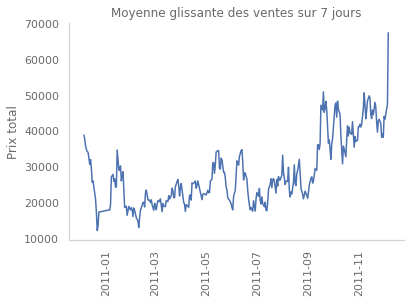

In [27]:
plt.plot(ventes.groupby('InvoiceDateSimple').TotalPrice.sum().rolling(7, center=True).mean())
plt.title("Moyenne glissante des ventes sur 7 jours")
plt.xticks(rotation=90)
plt.ylabel("Prix total")
plt.show()

## Produit

In [28]:
# Aggregation par ticket d'achat
last_order = df.InvoiceDate.max()
produits = df.groupby('InvoiceNo').agg({
    'InvoiceDate': ['max', 
                    lambda x: (last_order - pd.Series.max(x)).days],
    'CustomerID': [list, 
                  len],
    'Country': lambda x: pd.Series.mode(x)[0],
    'CountryGroup': lambda x: pd.Series.mode(x)[0],
    'StockCode': lambda x: pd.Series.mode(x)[0],
    'Quantity': 'sum',
    'TotalPrice': 'sum'
})

produits.columns = [
    'InvoiceDate', 'Recency','Customers','CustomerCount', 'Country', 'CountryGroup',
    'StockCode', 'TotalQty', 'TotalPrice'
]

produits['InvoiceDateSimple']=produits['InvoiceDate'].dt.date
produits.head()

,InvoiceDate,Recency,Customers,CustomerCount,Country,CountryGroup,StockCode,TotalQty,TotalPrice,InvoiceDateSimple
InvoiceNo,,,,,,,,,,
536365,2010-12-01 08:26:00,373,"[17850.0, 17850.0, 17850.0, 17850.0, 17850.0, ...",7,United Kingdom,UK,21730,40,139.12,2010-12-01
536366,2010-12-01 08:28:00,373,"[17850.0, 17850.0]",2,United Kingdom,UK,22632,12,22.20,2010-12-01
536367,2010-12-01 08:34:00,373,"[13047.0, 13047.0, 13047.0, 13047.0, 13047.0, ...",12,United Kingdom,UK,21754,83,278.73,2010-12-01
536368,2010-12-01 08:34:00,373,"[13047.0, 13047.0, 13047.0, 13047.0]",4,United Kingdom,UK,22912,15,70.05,2010-12-01
536369,2010-12-01 08:35:00,373,[13047.0],1,United Kingdom,UK,21756,3,17.85,2010-12-01


In [29]:
# CA par articles et par jours
dfp=produits.groupby(['InvoiceDateSimple','StockCode']).TotalPrice.sum().rolling(7, center=True).mean().dropna()
dfp=dfp.to_frame().reset_index()
dfp

,InvoiceDateSimple,StockCode,TotalPrice
0,2010-12-01,15056N,1255.298571
1,2010-12-01,15056P,1122.122857
2,2010-12-01,16237,1363.480000
3,2010-12-01,17021,1350.060000
4,2010-12-01,17091A,999.255714
5,2010-12-01,20668,1237.692857
6,2010-12-01,20679,1193.761429
...,...,...,...
15942,2011-12-09,22138,255.971429
15943,2011-12-09,22153,264.794286


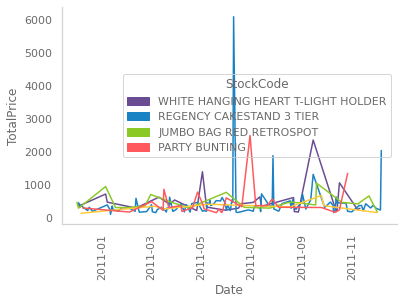

In [30]:
import matplotlib.patches as mpatches

maskP1=dfp['StockCode']=='85123A'
maskP2=dfp['StockCode']=='22423'
maskP3=dfp['StockCode']=='85099B'
maskP4=dfp['StockCode']=='84879'
maskP5=dfp['StockCode']=='47566'

cmap=({
    '85123A':'#6a4c93', 
    '22423':'#1982c4',
    '85099B':'#8ac926',
    '84879':'#ffca3a',
    '47566':'#ff595e'
})
# color patch legend
a_patch = mpatches.Patch(color=cmap['85123A'], label='WHITE HANGING HEART T-LIGHT HOLDER')
b_patch = mpatches.Patch(color=cmap['22423'], label='REGENCY CAKESTAND 3 TIER')
c_patch = mpatches.Patch(color=cmap['85099B'], label='JUMBO BAG RED RETROSPOT')
d_patch = mpatches.Patch(color=cmap['84879'], label='ASSORTED COLOUR BIRD ORNAMENT')
d_patch = mpatches.Patch(color=cmap['47566'], label='PARTY BUNTING')


plt.legend(title="StockCode",handles=[a_patch, b_patch, c_patch, d_patch],loc="right")

plt.plot(dfp[maskP1]['InvoiceDateSimple'], dfp[maskP1]['TotalPrice'],c=cmap['85123A'])
plt.plot(dfp[maskP2]['InvoiceDateSimple'], dfp[maskP2]['TotalPrice'],c=cmap['22423'])
plt.plot(dfp[maskP3]['InvoiceDateSimple'], dfp[maskP3]['TotalPrice'],c=cmap['85099B'])
plt.plot(dfp[maskP4]['InvoiceDateSimple'], dfp[maskP4]['TotalPrice'],c=cmap['84879'])
plt.plot(dfp[maskP5]['InvoiceDateSimple'], dfp[maskP5]['TotalPrice'],c=cmap['47566'])


plt.xlabel('Date')
plt.ylabel('TotalPrice')
plt.xticks(rotation=90)
plt.show()

In [31]:
# RFM sur le produit
dfRFMp=df.groupby('StockCode').agg({
        'Description': lambda x: pd.Series.mode(x)[0],
        'Country': lambda x: pd.Series.mode(x)[0],
        'CountryGroup': lambda x: pd.Series.mode(x)[0],
        'InvoiceDate': lambda x: (date_reference - x.max()).days,
        'InvoiceNo': 'count',
        'TotalPrice': 'sum'})

# frequence sur 7 jours
dfRFMp['Frequence7'] = (df.groupby('StockCode').InvoiceNo.nunique() / 
    (date_reference - df.groupby('StockCode').InvoiceDate.min()).dt.days * 7)
with pd.option_context('mode.use_inf_as_na', True):
        mean_freq = dfRFMp['Frequence7'].mean(skipna=True)
dfRFMp['Frequence7']=dfRFMp['Frequence7'].replace(np.inf, mean_freq) #remplacement des valeurs infinies par la moyenne


# Renomme les colonnes 
dfRFMp.rename(columns={'InvoiceDate': 'Recence',
                         'InvoiceNo': 'Frequence',
                         'TotalPrice': 'Montant'}, inplace=True)
dfRFMp.reset_index(inplace=True)

In [32]:
dfRFMp.sort_values(by=['Montant','Frequence'],ascending=False)

,StockCode,Description,Country,CountryGroup,Recence,Frequence,Montant,Frequence7
2399,23843,"PAPER CRAFT , LITTLE BIRDIE",United Kingdom,UK,1,1,168469.600,7.000000
1288,22423,REGENCY CAKESTAND 3 TIER,United Kingdom,UK,1,1714,142264.750,31.893048
3233,85123A,WHITE HANGING HEART T-LIGHT HOLDER,United Kingdom,UK,1,2023,100547.450,37.021390
3219,85099B,JUMBO BAG RED RETROSPOT,United Kingdom,UK,1,1615,85040.540,29.946524
1997,23166,MEDIUM CERAMIC TOP STORAGE JAR,United Kingdom,UK,1,198,81416.730,4.187117
3664,POST,POSTAGE,Germany,Europe,1,1099,77803.960,20.569519
2593,47566,PARTY BUNTING,United Kingdom,UK,1,1390,68785.230,25.967742
...,...,...,...,...,...,...,...,...
2811,84201C,HAPPY BIRTHDAY CARD TEDDY/CAKE,United Kingdom,UK,104,1,0.950,0.067308
2813,84206B,CAT WITH SUNGLASSES BLANK CARD,United Kingdom,UK,20,1,0.950,0.350000


<Figure size 2160x2160 with 0 Axes>

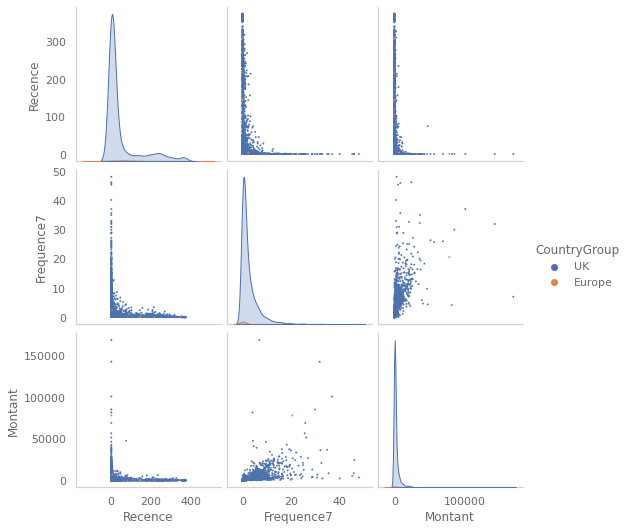

CPU times: user 2.27 s, sys: 22 ms, total: 2.3 s
Wall time: 2.31 s


In [33]:
%%time
plt.figure(figsize=(30,30))
sns.pairplot(
    data=dfRFMp[['Recence', 'Frequence7', 'Montant','CountryGroup']],
    hue='CountryGroup',
    plot_kws={'s': 3, "edgecolor": None},
)
plt.show()

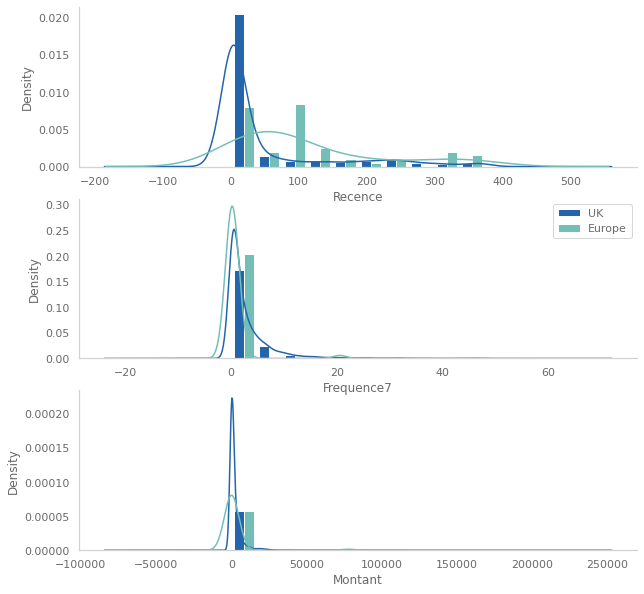

In [34]:
plt.figure(figsize=(10,10))
colors=['#2364aa', '#73bfb8']
bins=10

# RECENCE
plt.subplot(3, 1, 1);
plt.hist(
    [dfRFMp[dfRFMp['CountryGroup']=='UK']['Recence'],
     dfRFMp[dfRFMp['CountryGroup']=='Europe']['Recence']],
     color=colors,
     label=['UK','Europe','NotEurope'],
     density=True,
     bins=bins);
#plt.legend()
plt.xlabel('Recence')
plt.ylabel('Frequence')

# plot KDE
dfRFMp[dfRFMp['CountryGroup']=='UK']['Recence'].plot.kde(zorder=4, color=colors[0])
dfRFMp[dfRFMp['CountryGroup']=='Europe']['Recence'].plot.kde(zorder=4, color=colors[1])

# FREQUENCE
plt.subplot(3, 1, 2);

plt.hist(
    [dfRFMp[dfRFMp['CountryGroup']=='UK']['Frequence7'],
     dfRFMp[dfRFMp['CountryGroup']=='Europe']['Frequence7']],
     color=colors,
     label=['UK','Europe','NotEurope'],
     density=True,
     bins=bins);
plt.legend()
plt.xlabel('Frequence7')
plt.ylabel('Frequence7')

# plot KDE
dfRFMp[dfRFMp['CountryGroup']=='UK']['Frequence7'].plot.kde(zorder=2, color=colors[0])
dfRFMp[dfRFMp['CountryGroup']=='Europe']['Frequence7'].plot.kde(zorder=2, color=colors[1])

# MONTANT
plt.subplot(3, 1, 3);
plt.hist(
    [dfRFMp[dfRFMp['CountryGroup']=='UK']['Montant'],
     dfRFMp[dfRFMp['CountryGroup']=='Europe']['Montant']],
     color=colors,
     label=['UK','Europe','NotEurope'],
     density=True,
     bins=bins);
#plt.legend()
plt.xlabel('Montant')
plt.ylabel('Frequence')

# plot KDE
dfRFMp[dfRFMp['CountryGroup']=='UK']['Montant'].plot.kde(zorder=4, color=colors[0])
dfRFMp[dfRFMp['CountryGroup']=='Europe']['Montant'].plot.kde(zorder=4, color=colors[1])

plt.show()


In [35]:
# produit par date (format: yy-mm)
dfStockPerDate=df.groupby(['InvoiceDateYM','StockCode']).agg({
    'Description':lambda x: pd.Series.mode(x)[0],
    'InvoiceNo':'count'
})
dfStockPerDate.rename(columns={'InvoiceNo':'Count'},inplace=True)
dfStockPerDate.reset_index(inplace=True)
dfStockPerDate

,InvoiceDateYM,StockCode,Description,Count
0,2010-12,10002,INFLATABLE POLITICAL GLOBE,16
1,2010-12,10120,DOGGY RUBBER,4
2,2010-12,10123C,HEARTS WRAPPING TAPE,1
3,2010-12,10124A,SPOTS ON RED BOOKCOVER TAPE,1
4,2010-12,10124G,ARMY CAMO BOOKCOVER TAPE,1
5,2010-12,10125,MINI FUNKY DESIGN TAPES,7
6,2010-12,10133,COLOURING PENCILS BROWN TUBE,13
...,...,...,...,...
30400,2011-12,90214Y,"LETTER ""Y"" BLING KEY RING",2
30401,2011-12,90214Z,"LETTER ""Z"" BLING KEY RING",1


In [36]:
# les 10 articles les plus vendus
dfStockCodeList=dfStockPerDate.groupby('StockCode').agg({
    'Description':lambda x: pd.Series.mode(x)[0],
    'Count':'sum'
}).sort_values('Count',ascending=False)
dfStockCodeList.head(10)

,Description,Count
StockCode,,
85123A,WHITE HANGING HEART T-LIGHT HOLDER,2023
22423,REGENCY CAKESTAND 3 TIER,1714
85099B,JUMBO BAG RED RETROSPOT,1615
84879,ASSORTED COLOUR BIRD ORNAMENT,1395
47566,PARTY BUNTING,1390
20725,LUNCH BAG RED RETROSPOT,1304
22720,SET OF 3 CAKE TINS PANTRY DESIGN,1152
POST,POSTAGE,1099
23203,JUMBO BAG VINTAGE DOILY,1089


In [37]:
xy1=dfStockPerDate[dfStockPerDate['Description']==dfStockCodeList.iloc[0]['Description']]
xy2=dfStockPerDate[dfStockPerDate['Description']==dfStockCodeList.iloc[1]['Description']]
xy3=dfStockPerDate[dfStockPerDate['Description']==dfStockCodeList.iloc[2]['Description']]
xy4=dfStockPerDate[dfStockPerDate['Description']==dfStockCodeList.iloc[3]['Description']]
xy5=dfStockPerDate[dfStockPerDate['Description']==dfStockCodeList.iloc[4]['Description']]
xy6=dfStockPerDate[dfStockPerDate['Description']==dfStockCodeList.iloc[5]['Description']]

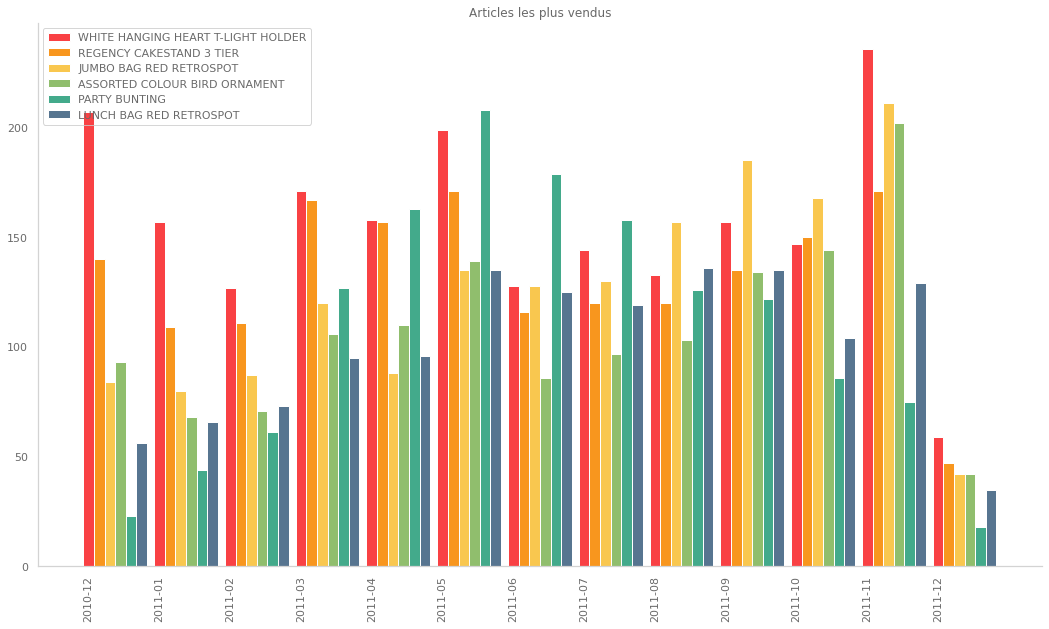

In [38]:
# Assigne une couleur par produit
colors = ['#f94144','#f8961e','#f9c74f','#90be6d','#43aa8b','#577590']
names = dfStockCodeList.index

plt.figure(figsize=(18,10))

bar_width = 0.15
x=np.arange(len(xy1['InvoiceDateYM']))

# histogramme en utilisant une liste de liste
plt.bar(x,xy1['Count'],color=colors[0],label=dfStockCodeList.iloc[0]['Description'],width=bar_width)
plt.bar(x+bar_width,xy2['Count'],color=colors[1],label=dfStockCodeList.iloc[1]['Description'],width=bar_width)
plt.bar(x+bar_width*2,xy3['Count'],color=colors[2],label=dfStockCodeList.iloc[2]['Description'],width=bar_width)
plt.bar(x+bar_width*3,xy4['Count'],color=colors[3],label=dfStockCodeList.iloc[3]['Description'],width=bar_width)
plt.bar(x+bar_width*4,xy5['Count'],color=colors[4],label=dfStockCodeList.iloc[4]['Description'],width=bar_width)
plt.bar(x+bar_width*5,xy6['Count'],color=colors[5],label=dfStockCodeList.iloc[5]['Description'],width=bar_width)



plt.xticks( np.arange(13), list(xy1['InvoiceDateYM']),rotation=90)
plt.title('Articles les plus vendus')
plt.legend()
plt.show()

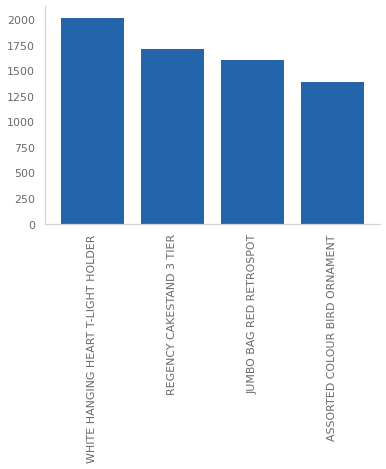

In [39]:
dfTopFrequencies=dfRFMp.sort_values(by=['Frequence'],ascending=False).head(4)
plt.bar(dfTopFrequencies['Description'],dfTopFrequencies['Frequence'],color='#2364aa');
plt.xticks(rotation=90)
plt.ylabels='Frequence'
plt.show()

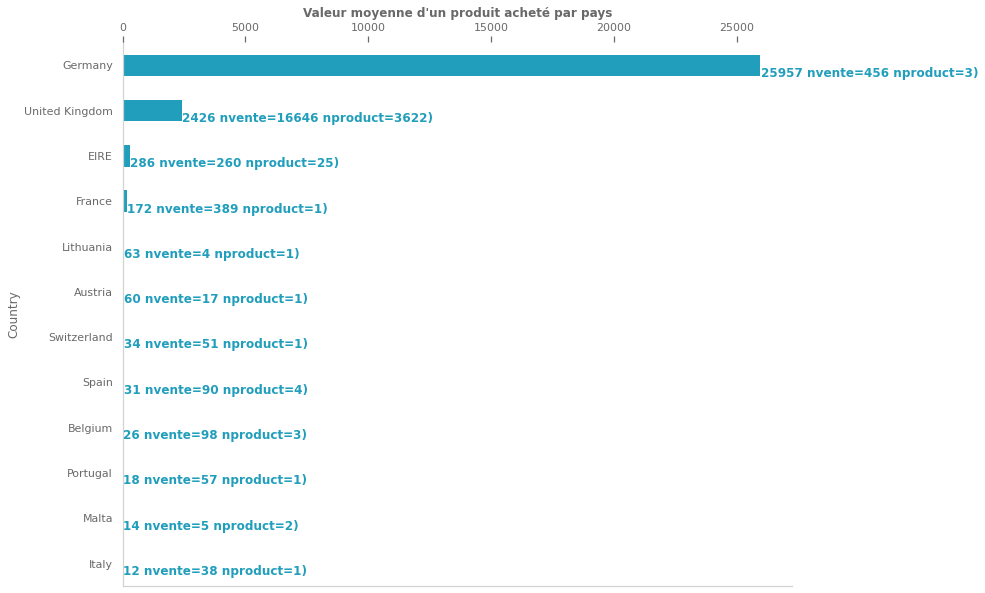

In [40]:
means = dfRFMp.groupby('Country').Montant.mean().sort_values(ascending=False)
n_product = dfRFMp.groupby('Country').StockCode.nunique()
n_vente = ventes.groupby('Country').size()
graphColor='#219ebc'

fig, ax = plt.subplots(figsize=(12,10))
means.plot.barh(ax=ax, color=graphColor)
plt.gca().invert_yaxis()
ax.set_title("Valeur moyenne d'un produit acheté par pays", fontweight='bold')
ax.xaxis.tick_top()
for i, (country, val) in enumerate(means.items()):
    text = f"{str(round(val))} nvente={n_vente.loc[country]} nproduct={n_product.loc[country]})"
    ax.text(val + 10, i + .25, text, color=graphColor, fontweight='bold')
plt.show()

In [41]:
# mots les plus utilisés
words=sum([x.split() for x in dfRFMp['Description']],[])

In [42]:
# mots les plus utilisés
word_counts=collections.Counter(words)
word_counts

dfWordCount=pd.DataFrame(list(word_counts.items()),columns = ['word','count'])
dfWordCount.sort_values('count',ascending=False)

,word,count
38,PINK,278
71,SET,256
159,OF,226
124,HEART,216
40,BLUE,207
362,VINTAGE,196
12,RED,186
...,...,...
1510,TOILETTE,1
1511,SPATULA,1
